# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [2]:
# for linux
#%sudo apt-get install poppler-utils tesseract-ocr libmagic-dev
!apt-get update && apt-get install -y poppler-utils tesseract-ocr libmagic-dev
# for mac
# %brew install poppler tesseract libmagic

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [3]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from google.colab import userdata

In [5]:
import os

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [6]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [9]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/images"
#file_path = output_path + 'attention.pdf'
file_path = 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    extract_images_in_pdf=True,          # deprecated
)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [10]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [11]:
len(chunks)

12

In [12]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[10]

In [13]:
elements = chunks[10].metadata

In [14]:
type(chunks[10])

unstructured.documents.elements.CompositeElement

In [15]:
elements.to_dict()

{'filetype': 'application/pdf',
 'languages': ['eng'],
 'last_modified': '2025-04-05T15:28:30',
 'page_number': 10,
 'orig_elements': 'eJzFXFtz2ziy/iuoPM1UCRriRhB5OeVcJxdnsnF2Z+bMuqZAEpS4pkgtL3bsrfPfTzdAyZYtZyNNSclDLLbUvOFD99cX4I//PHGVW7i6/7PMnzwlTwqbF4W1ghpnOJVMaJpwmVJpE2uddSLn5smEPFm43ua2t6DznydZ07R5Wdvedf64stfN0P85d+Vs3oOE8ygCnVF8Veb9HKRMe+myKese9f74gxs91RPCIsan8fmE3AqkmiYoUIxN2VaBVwHJk+66690Cn+Vj+cVVZ0ubuSf/B1/krndZXzb1n1llu+7PZduk8LNoahhnCfygKCvXXy+d1/14+sTfcj0b7Mw/1x9PXD17cu6lXf/nosnLonT+rfGIKxpJGqnPTD3lyVMRofYSNP+sh0XqWnzeCO+id1/wlTzR5HlTZ9XQwQ3hb1cX/lz2lb/f+yMTK50UmkXUMe2ozASjKRcZzY10rihcZu1hR0bia06iKVuNDApYnEwlCpiMkmm0VRKU9hwbCec79ti8qUk/Lzty1bQXE3LlyLJ1HYyEy0HuyOfW1l3RtAvXTrygKNuuJ5379+DqzJEev88H/zwEbsVVJLUdKMMpytZV1wTktu/xsKknpHXLymZlPfMna102tC18R2BUXNvBGeDkWbNYNDWoDniisoZzZXDmlubO/yW2zeYlvsQB7pVclf2cLIaqL+nc2RxUOlcVdH3R6V3IfbBta/vy0n3G598CvVQ5rV0W0SizCZWRS2lSwFt1TEQqYVHG4/Sg0DOIqySeihX0UCAiOTUBaCx6RBKU9oVezNWxofeqaQN+Kuvh09vuopvchx3JbE1Sj7SyxsEtZzVcFaQ9QKSA+4Df9HP40SYsAgzht

In [16]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '8e0c688f-e39f-4f25-9764-ee465d10ceb9',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-04-05T15:28:30',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

### Separate extracted elements into tables, text, and images

In [17]:
# separate texts
texts = []

for chunk in chunks:
      if "CompositeElement" in str(type((chunk))):
          texts.append(chunk)

In [18]:
texts

In [19]:
# Get the Tables from the CompositeElement objects
def get_tables(chunks):
    tables = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Table" in str(type(el)):
                    print("table found")
                    tables.append(el)
                    print(el.metadata.text_as_html)

    return tables

tables = get_tables(chunks)

table found
<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n - d?)</td><td>O(n)</td><td>O(n)</td></tr><tr><td>Convolutional</td><td>O(k-n-d?)</td><td>O(1)</td><td>O(logx(n))</td></tr><tr><td>Self-Attention (restricted)</td><td>O(r-n-d)</td><td>ol)</td><td>O(n/r)</td></tr></tbody></table>
table found
<table><thead><tr><th>Model</th><th>EN-DE</th><th>BLEU EN-FR</th><th>Training EN-DE</th><th>Cost (FLOPs) EN-FR</th></tr></thead><tbody><tr><td colspan="5">ByteNet [18] 23.75</td></tr><tr><td>Deep-Att + PosUnk</td><td></td><td>39.2</td><td></td><td>1.0 - 107°</td></tr><tr><td>GNMT + RL 8]</td><td>24.6</td><td>39.92</td><td>2.3-10!9</td><td>1.4. 1070</td></tr><tr><td>ConvS28S [9]</td><td>25.16</td><td>40.46</td><td>9.6-10'%</td><td>1.5-1070</td></tr><tr><td>MoE</td><td>26.03</td><td>40.56</td><t

In [20]:
len(tables)

4

In [21]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [22]:
len(images)

7

#### Check what the images look like

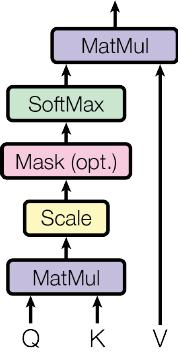

In [23]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[1])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [24]:
%pip install -Uq langchain-groq

In [25]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [26]:
from langchain_openai import ChatOpenAI

In [27]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
#model = ChatGroq(temperature=0.5, model="llama-3.3-70b-versatile")
model = ChatOpenAI(model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [29]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

In [30]:
text_summaries

['The document presents the "Transformer," a novel network architecture proposed by a team from Google and the University of Toronto, which relies solely on attention mechanisms instead of recurrent or convolutional networks. The Transformer outperforms existing models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, while being more parallelizable and requiring less training time. The authors assert its versatility by successfully applying it to English constituency parsing as well.',
 'Recurrent neural networks, particularly long short-term memory and gated recurrent networks, are established in sequence modeling like language and translation tasks, but they face challenges with sequential computation that limits parallelization. Attention mechanisms enhance models by allowing dependency modeling across distances, often used alongside recurrent networks. The Transformer is introduced as a novel architecture that utiliz

In [31]:
# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [32]:
table_summaries

['The table compares different layer types in terms of complexity, sequential operations, and maximum path length. Self-Attention has a complexity of O(n? - d), with constant sequential operations and a maximum path length of O(1). Recurrent layers exhibit O(n - d?) complexity, O(n) sequential operations, and a maximum path length of O(n). Convolutional layers have a complexity of O(k-n-d?), constant sequential operations, and a logarithmic maximum path length of O(logx(n)). Restricted Self-Attention has a complexity of O(r-n-d), represented as ol for sequential operations, and a maximum path length of O(n/r).',
 'The table lists various translation models along with their performance metrics. Key points include:\n\n- ByteNet: EN-DE score of 23.75.\n- Deep-Att + PosUnk: BLEU EN-FR score of 39.2 with cost of 1.0 x 10^7 FLOPs.\n- GNMT + RL: EN-DE score of 24.6, BLEU EN-FR 39.92, training cost ranging from 2.3 x 10^9 to 1.4 x 10^70 FLOPs.\n- ConvS28S: Exhibits EN-DE of 25.16 and BLEU of 4

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [33]:
%pip install -Uq langchain_openai

In [34]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [35]:
image_summaries

['The image illustrates the architecture of a Transformer model, a foundational structure in deep learning, especially for natural language processing tasks. It features a flowchart design with various components connected by arrows, indicating the data flow through the model.\n\n### Key Components:\n\n1. **Input/Output Embeddings**:\n   - At the bottom, there\'s a section for "Input Embedding" and "Output Embedding," indicating how input data is transformed into a format usable by the model. Outputs are described as being "shifted right," illustrating that the output sequence is typically prepared in a way that considers the previous tokens.\n\n2. **Positional Encoding**:\n   - Above the input and output embeddings, there are symbols representing "Positional Encoding." This indicates that positional information is added to the embeddings to give the model a sense of the order of the tokens.\n\n3. **Encoder Block (left)**:\n   - The left side of the diagram is dedicated to the Encoder 

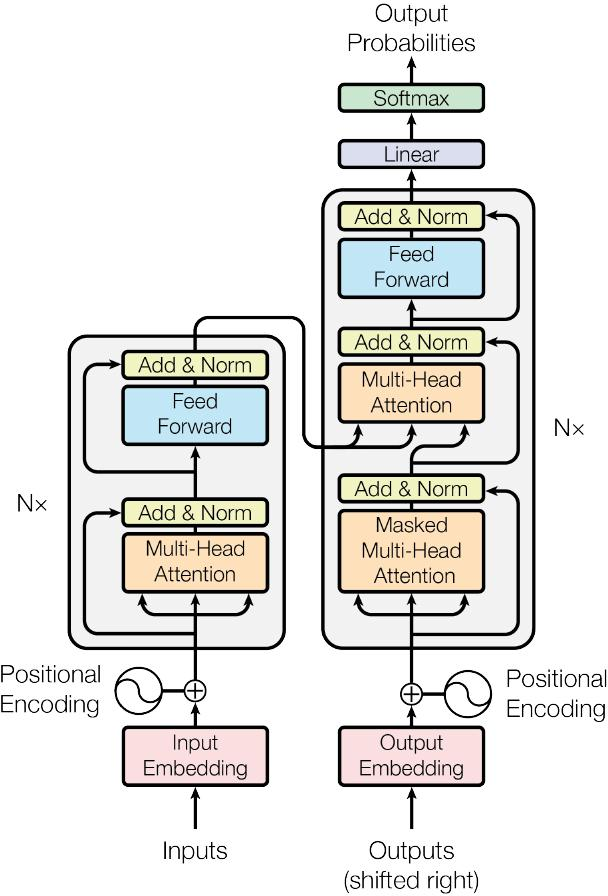

In [36]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [37]:
print(image_summaries[0])

The image illustrates the architecture of a Transformer model, a foundational structure in deep learning, especially for natural language processing tasks. It features a flowchart design with various components connected by arrows, indicating the data flow through the model.

### Key Components:

1. **Input/Output Embeddings**:
   - At the bottom, there's a section for "Input Embedding" and "Output Embedding," indicating how input data is transformed into a format usable by the model. Outputs are described as being "shifted right," illustrating that the output sequence is typically prepared in a way that considers the previous tokens.

2. **Positional Encoding**:
   - Above the input and output embeddings, there are symbols representing "Positional Encoding." This indicates that positional information is added to the embeddings to give the model a sense of the order of the tokens.

3. **Encoder Block (left)**:
   - The left side of the diagram is dedicated to the Encoder with a repeate

## Load data and summaries to vectorstore

### Create the vectorstore

In [38]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

<ipython-input-38-97639e9e5eb4>:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())


### Load the summaries and link the to the original data

In [39]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

## RAG pipeline

In [40]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [41]:
response = chain.invoke(
    "What BLEU score for model ByteNet"
)

print(response)

The BLEU score for the model ByteNet is 23.75.


Response: The attention mechanism is a pivotal component in modern neural networks, particularly in natural language processing tasks. It allows the model to focus on different parts of the input sequence when generating an output. 

**Explanation of Attention Mechanism:**

1. **Concept**: At its core, attention compares various parts of an input sequence to capture relationships and dependencies based on their relevance to a specific output state. This allows the model to weigh the importance of each word (or symbol) when processing an input.

2. **Self-Attention**: This mechanism computes the relationships between different positions of a single input sequence. It generates a contextual representation for each word, considering all other words in the sequence. 

### Images Explanation:

1. **First Image**: This illustrates the attention scores between different words in a sequence, represented by the green lines. The thickness of the lines indicates the strength of attention, showing

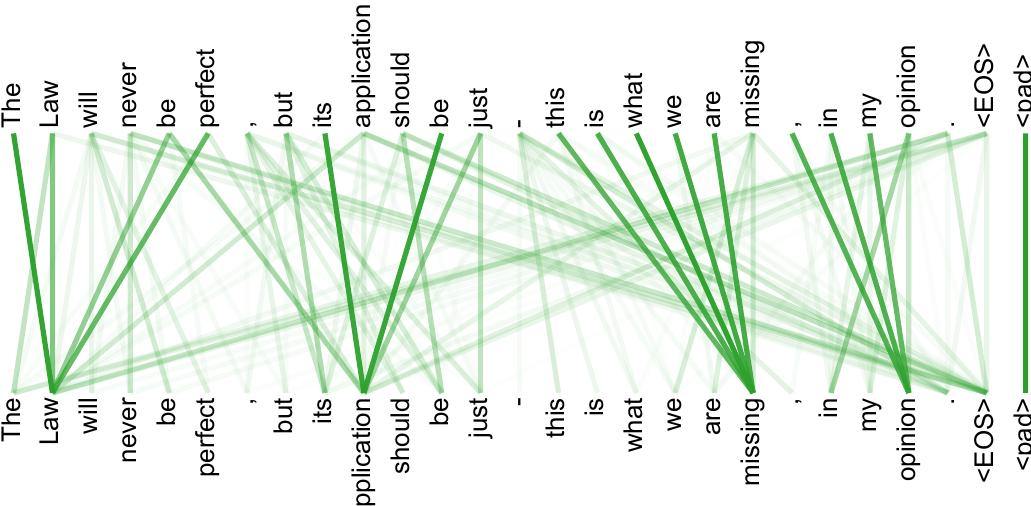

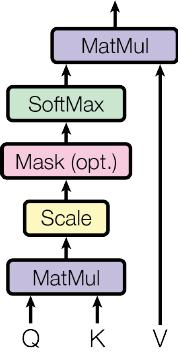

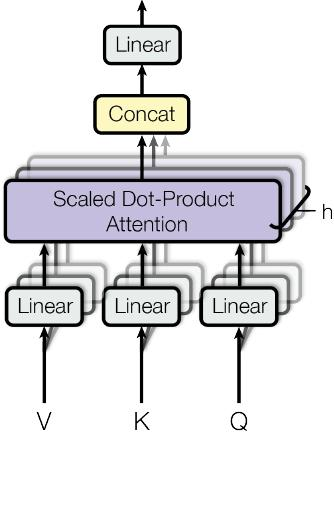

In [42]:
response = chain_with_sources.invoke(
    "What is attention mechanism, explain with image"
)

print("Response:", response['response'])

#print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)